## ewf-ext-02-03-02 - NDVI growing season statistics time series per pixel

NDVI growing season statistics time series per pixel

---

### <a name="service">Service definition

In [1]:
service = dict([('title', 'NDVI growing season statistics time series per pixel'),
                ('abstract', 'NDVI growing season statistics time series per pixel'),
                ('id', 'ewf-ext-02-03-02')])

### <a name="parameter">Parameter Definition 

In [2]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

In [3]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'P001'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

In [4]:
ndviIndex = dict([('id', 'ndviIndex'),
             ('value', 'better-ext-02-03-01'),
             ('title', 'ndvi catalog index'),
             ('abstract', 'index to access ndvi catalog'),
             ('minOccurs', '1')])

In [5]:
ndviApikey = dict([('id', 'ndviApikey'),
                ('value', ''),
                ('title', 'ndvi catalog apikey'),
                ('abstract', 'apikey to access ndvi catalog'),
                ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the NDVI stack of products' identifiers

In [6]:
# 2014, 2015, 2016, 2017
#input_identifiers = ('LE07_L1TP_204033_20140311_20161117_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140428_20161116_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140514_20161115_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140530_20161115_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140615_20161113_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140701_20161112_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140717_20161112_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140818_20161111_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20141208_20161030_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20141224_20161030_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150109_20161030_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150125_20161029_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150314_20161028_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150330_20161028_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150517_20161026_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150602_20161025_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150618_20161025_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150704_20161024_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150720_20161027_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150805_20161023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150821_20161022_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150922_20161019_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151008_20161018_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151109_20161017_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151227_20161016_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160112_20161015_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160229_20161014_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160401_20161013_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160503_20161011_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160519_20161010_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160620_20161209_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160706_20161009_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160722_20161010_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160807_20161008_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160823_20161007_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160908_20161006_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160924_20161023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161026_20161121_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161127_20170118_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161229_20170219_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170114_20170209_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170319_20170414_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170404_20170430_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170420_20170516_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170506_20170601_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170522_20170617_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170607_20170703_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170623_20170719_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170709_20170804_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170725_20170820_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170810_20170905_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170826_20170921_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170911_20171007_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170927_20171023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171013_20171110_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171029_20171124_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171114_20171210_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171130_20171226_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171216_20180111_01_T1_sr_NDVI.tif')

# 2014
#input_identifiers = ('LE07_L1TP_204033_20140311_20161117_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140428_20161116_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140514_20161115_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140530_20161115_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140615_20161113_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140701_20161112_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140717_20161112_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140818_20161111_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20141208_20161030_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20141224_20161030_01_T1_sr_NDVI.tif')

# 2015
#input_identifiers = ('LE07_L1TP_204033_20150109_20161030_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150125_20161029_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150314_20161028_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150330_20161028_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150517_20161026_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150602_20161025_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150618_20161025_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150704_20161024_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150720_20161027_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150805_20161023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150821_20161022_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150922_20161019_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151008_20161018_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151109_20161017_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151227_20161016_01_T1_sr_NDVI.tif')

# 2016
#input_identifiers = ('LE07_L1TP_204033_20160112_20161015_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160229_20161014_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160401_20161013_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160503_20161011_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160519_20161010_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160620_20161209_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160706_20161009_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160722_20161010_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160807_20161008_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160823_20161007_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160908_20161006_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160924_20161023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161026_20161121_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161127_20170118_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161229_20170219_01_T1_sr_NDVI.tif')

# 2017
#input_identifiers = ('LE07_L1TP_204033_20170114_20170209_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170319_20170414_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170404_20170430_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170420_20170516_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170506_20170601_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170522_20170617_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170607_20170703_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170623_20170719_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170709_20170804_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170725_20170820_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170810_20170905_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170826_20170921_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170911_20171007_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170927_20171023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171013_20171110_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171029_20171124_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171114_20171210_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171130_20171226_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171216_20180111_01_T1_sr_NDVI.tif')


#input_identifiers = ('LE07_L1TP_204033_20140311_20161117_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140428_20161116_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140514_20161115_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140530_20161115_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140615_20161113_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140701_20161112_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140717_20161112_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140818_20161111_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20141208_20161030_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20141224_20161030_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150109_20161030_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150125_20161029_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150314_20161028_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150330_20161028_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150517_20161026_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150602_20161025_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150618_20161025_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150704_20161024_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150720_20161027_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150805_20161023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150821_20161022_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150922_20161019_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151008_20161018_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151109_20161017_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151227_20161016_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160112_20161015_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160229_20161014_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160401_20161013_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160503_20161011_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160519_20161010_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160620_20161209_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160706_20161009_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160722_20161010_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160807_20161008_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160823_20161007_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160908_20161006_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160924_20161023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161026_20161121_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161127_20170118_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161229_20170219_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170114_20170209_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170319_20170414_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170404_20170430_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170420_20170516_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170506_20170601_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170522_20170617_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170607_20170703_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170623_20170719_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170709_20170804_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170725_20170820_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170810_20170905_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170826_20170921_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170911_20171007_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170927_20171023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171013_20171110_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171029_20171124_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171114_20171210_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171130_20171226_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171216_20180111_01_T1_sr_P001_NDVI.tif')




# 2014
#input_identifiers = ('LE07_L1TP_204033_20140311_20161117_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140428_20161116_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140514_20161115_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140530_20161115_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140615_20161113_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140701_20161112_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140717_20161112_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140818_20161111_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20141208_20161030_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20141224_20161030_01_T1_sr_P001_NDVI.tif')

# 2015
#input_identifiers = ('LE07_L1TP_204033_20150109_20161030_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150125_20161029_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150314_20161028_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150330_20161028_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150517_20161026_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150602_20161025_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150618_20161025_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150704_20161024_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150720_20161027_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150805_20161023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150821_20161022_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150922_20161019_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151008_20161018_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151109_20161017_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151227_20161016_01_T1_sr_P001_NDVI.tif')

input_identifiers = ('0CFC36158132DA794782B428E6DF76E7DC4C07CD', '4F49AF0E4B772965258B1AD001423D60228BB49A', '82A433CFFE0F4115F8A4BBFFDCB1C3D6A5709427', '487C80B2EF22D66AB8F10F65A7CBD6BAFB3E3939', '87E43FB9A02BE617A7A731DDD668B661B6EBCE07', '03F1348D9DCDC9A1E1A2B544E76C92420E70A31A', 'C72F7439E9A8853E8D64B44E52A0D24CF797F6E6', '164BB5EE04E403530B3C87F0ECDF4E95C54188B8', '1E44F63186475D883CDB9FED5E2ACB8CA992A9DF', '01D316DE31BAD714AF0F9B0CFCEED5E7697BC09F', '0E314958DD97CF88FF11F81147CE52AF3FD13B4A', 'C812DC63D58400C16515C79F8C4BCA32332B2724', 'B8EF89460AF0FE1344881FBEF5E533371BD6C404', 'A27CAA804DDA8A3B9256D1E4B9E080031E6BEBCD', '2DA8C200ABE9599DD7D5BDB155B0BE1922E2F139')

# 2016
##input_identifiers = ('LE07_L1TP_204033_20160112_20161015_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160229_20161014_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160401_20161013_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160503_20161011_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160519_20161010_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160620_20161209_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160706_20161009_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160722_20161010_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160807_20161008_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160823_20161007_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160908_20161006_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160924_20161023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161026_20161121_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161127_20170118_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161229_20170219_01_T1_sr_P001_NDVI.tif')

#input_identifiers = ('496D00DB33D88356DAE2C344516FD5D699C1F5DE', 'B073C856BA5FD6453B08C04527FFB95DA622FFC1', '1067AFC0B24F69C2050F093DE7F110E4419174F4', 'C438B6CB4131CEBFF6741926B03B7E137641AF4C', '9C2C13C121F71803FC1E697C306C9603B6680303', 'E74B265D5CF4626BF6F360B6379D409AA5D3B8A8', '83F48D641924F90544ED66C701B36BF0E65153C8', 'F3FD3FF45ECC114A665F6C239F6812DE7786A98F', '952AC4BFAB859E9F68762A61D206D690726AF431', 'B726A411FF02675367B07D82059B2E0945C1F3DA', 'D4DFDC63732D33DB14B9E7B3D34D5BF732547F6F', '8F51A4ED9AB3DB6DC5920B06382817C28C2D1A3B', 'E21111899ECFAF1AA5A991D625B2F00BE68024E3', '944CC689671685BC84E5DBBF95A12E0825B85C81', 'A1A83855BF03D91480273FE5C32D1AA33BB77715')

# 2017
##input_identifiers = ('LE07_L1TP_204033_20170114_20170209_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170319_20170414_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170404_20170430_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170420_20170516_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170506_20170601_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170522_20170617_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170607_20170703_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170623_20170719_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170709_20170804_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170725_20170820_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170810_20170905_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170826_20170921_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170911_20171007_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170927_20171023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171013_20171110_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171029_20171124_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171114_20171210_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171130_20171226_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171216_20180111_01_T1_sr_P001_NDVI.tif')

#input_identifiers = ('23CFAEB3EABC76DEB761059E5358AAAA7E6B73C0', '8413BCE5866586CFA8C228F42F4A0857689C20CF', '1559F9C271D8D9133AED47EFB4F253B3E8214701', 'C8D85D9F1D4BFCBC2132F878802D28400E42D35D', 'E8EA192CE196DA08137D8C3D99D5613F51DBB4F6', 'CDED3F2A35002477AC57692830E1D68D066ED4D2', '272816AC6E6E655F0F7247C7C9DA7608B2408893', 'C4F69F8C3AEA1C2C958AB0F97A4D85DCF9CB96CB', 'FED212ED127A33D5B06F95ABD582DAB981C82772', '945E4464682095D6DB964AF430BD53357D54E140', 'FC482A14CE3A63BBDF1CBF591AD9F9E2ECFF58E7', '6B5834E426558BF0F5D167D164C6F1F5EE1D0FFD', '73288D3159115BF7AAEAA049F023340691C0E121', 'D6D4200A3247562D2EA893F23E6B9DB36FA87687', 'A391B46EAEA2CC4E32207B8909B5E991EBFD96E0', 'F3FDC848CD9781ADCF2D85A611ED40CE7E23F454', '6D5DED33A75AF7793F2D62E15692962085730DD9', '62499DA2F0E79F68B86692B468503FD8D9FFDBA2', '07CE2DB5EEE4121950D91543518D4C9A69ED504E')


**Input references**

This is the NDVI stack catalogue references

In [7]:
input_references = tuple(['https://catalog.terradue.com/better-ext-02-03-01/search?format=atom&uid={0}'.format(pid) for pid in input_identifiers])

**Data path**

This path defines where the data is staged-in. 

In [8]:
data_path = "/workspace/dev/ewf-ext-02-03-01/src/main/app-resources/notebook/libexec"
data_path = "/workspace/dev/ewf-ext-02-03-01/src/main/app-resources/notebook/libexec/parcel"

**Aux folders**

In [9]:
output_folder = ''

In [10]:
temp_folder = 'temp'

#### Import Modules

In [11]:
import os
import shutil

import sys
import string
import numpy as np
import numpy.ma as ma
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import matplotlib
import matplotlib.pyplot as plt

import datetime

import pdb


sys.path.append(os.getcwd())
sys.path.append('/application/notebook/libexec/')
from s2_whittaker_helpers import *
from whittaker import ws2d, ws2doptv, ws2doptvp
import array

import pandas as pd
import geopandas as gpd

import cioppy
ciop = cioppy.Cioppy()

#### Auxiliary vars

In [59]:
check_results = False

#### Auxiliary methods

In [13]:
# remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
            

def get_input_metadata (input_refs):
    
    # for each product get metadata
    Result_Prod = []
    
    for index,product_ref in enumerate(input_refs):
        
        # since the search is by identifier 
        Result_Prod.append(ciop.search(end_point = product_ref,params =[],output_fields='self,identifier,startdate,enclosure,startdate,enddate,wkt,title',creds='{}:{}'.format(ndviIndex['value'],ndviApikey['value']))[0] )
    

    input_metadata = gpd.GeoDataFrame.from_dict(Result_Prod)

    input_metadata['startdate'] = pd.to_datetime(input_metadata['startdate'])
    input_metadata['enddate'] = pd.to_datetime(input_metadata['enddate'])
    
    return input_metadata            

            
            
def get_matrix_list(image_list, mask_value = None):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        
        if mask_value is not None:
             product_array = ma.masked_values (product_array, mask_value)
        
        mat_list.append(product_array)
        dataset = None
    return mat_list



def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type

def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)



        
        
        
def get_formatted_date(datetime_str):
    date = datetime.datetime.strftime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    
    first_date_str = datetime.datetime(year=first_date.year, month=first_date.month, day=first_date.day)
    first_date_str = first_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    first_date_str = get_formatted_date(first_date_str)
    
    last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
    last_date_str = last_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    last_date_str = get_formatted_date(last_date_str)
    
    if (first_date_str == last_date_str):
        last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
        last_date_str = last_date_str + datetime.timedelta(days=0, hours=23, minutes=59, seconds=59)
        last_date_str = get_formatted_date(last_date_str)
    
    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (region_of_interest))
        
        
        
def ndvi_filter (ts_ndvi_dates, ts_ndvi):
    
    
    dates_a = np.array(ts_ndvi_dates)
    ndvi_values_a = np.array(ts_ndvi, dtype='double')
    
    # remove no values
    dates_a = dates_a[ndvi_values_a > -9998]
    ndvi_values_a = ndvi_values_a[ndvi_values_a > -9998]
    
    
    dates_jul = [d.strftime('%Y%j') for d in dates_a]

    dates_jul2 = [str(a) for a in range(int(str(ts_ndvi_dates[0].year) + '001'), int(str(ts_ndvi_dates[0].year) + '001')+365)]

    indate = dates_jul2[4]

    ##### create weights
    w = np.array((ndvi_values_a!=-9999)*1,dtype='double')

    lrange = np.linspace(-1,1,11)

    # apply whittaker filter with V-curve
    z, lopt = ws2doptv(ndvi_values_a,w,array.array('d',lrange)) # In the original script the function is ws2d_vc, which is defined in modis.py.


    ### Temporal interpolation

    # little helper objects for managing dates (rtres = raw tem. resolution, stres = desired output temporal resolution)
    #dhelper = DateHelper(rawdates=dates, rtres=8, stres=10)

    dhelper = DateHelper(rawdates=dates_jul2, rtres=1, stres=15, start=indate)
    # daily vector
    dvec = dhelper.getDV(nd=-9999)

    # target date index 
    dix = dhelper.getDIX()


    # shift observations to midpoint of acquisition (these positions are set to 0 instead of nodata)
    for d in dates_jul:
        dvec[dhelper.daily.index((fromjulian(d) + datetime.timedelta(1)).strftime('%Y%j'))] = 0

    dvec[ dvec != -9999 ] = z

    w = np.array((dvec != -9999) * 1,dtype='double')

    dvec =  ws2d(dvec,0.0001,w)

    z_int = np.array(dvec)[dix]

    # plot

    xax1 = [fromjulian(x) for x in dates_jul]
    xax2 = [fromjulian(x) for x in dhelper.target]

    #plt.close()
    #plt.figure(figsize=(15,8))
    ##plt.ylim(0,1)
    #plt.plot(xax1, ndvi_values_a, label='y')
    #plt.plot(xax1, z, 'rs', label='z', alpha=0.7)
    #plt.plot(xax2, z_int, 'go--', label='z_int', alpha=0.5)


   
    #plt.xlim((datetime.datetime(dates[0].year, 1, 1, 0, 0), datetime.datetime(dates[0].year, 12, 31, 0, 0)))
    #plt.ylim((-1, 1))

    #plt.legend()

    #plt.savefig('ndvi_' + str(dates[0].year) + '.png', dpi=300)

    #plt.show()
    
    return xax2, z_int



def get_formatted_date(datetime_str):
    date = datetime.datetime.strftime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
 
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    
    first_date_str = datetime.datetime(year=first_date.year, month=first_date.month, day=first_date.day)
    first_date_str = first_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    first_date_str = get_formatted_date(first_date_str)
    
    last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
    last_date_str = last_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    last_date_str = get_formatted_date(last_date_str)
    
    if (first_date_str == last_date_str):
        last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
        last_date_str = last_date_str + datetime.timedelta(days=0, hours=23, minutes=59, seconds=59)
        last_date_str = get_formatted_date(last_date_str)

    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date_str, last_date_str))
        file.write('geometry=%s' % (region_of_interest))

#### Auxiliary folders

In [14]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

### Workflow

Load metadata from catalog

In [15]:
message = 'Loading metadata from catalog' 
ciop.log('INFO', message)

input_metadata = get_input_metadata (input_references)

# order by startdate
input_metadata = input_metadata.sort_values(by='startdate')


reporter:status:2019-10-24T12:15:31.246380 [INFO   ] [user process] Loading metadata from catalog
2019-10-24T12:15:31.246380 [INFO   ] [user process] Loading metadata from catalog


In [16]:
input_metadata

,enclosure,enddate,identifier,self,startdate,title,wkt
0,https://store.terradue.com/better-ext-02-03-01...,2015-01-09 23:59:59,0CFC36158132DA794782B428E6DF76E7DC4C07CD,https://catalog.terradue.com/better-ext-02-03-...,2015-01-09,Output LE07_L1TP_204033_20150109_20161030_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
1,https://store.terradue.com/better-ext-02-03-01...,2015-01-25 23:59:59,4F49AF0E4B772965258B1AD001423D60228BB49A,https://catalog.terradue.com/better-ext-02-03-...,2015-01-25,Output LE07_L1TP_204033_20150125_20161029_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
2,https://store.terradue.com/better-ext-02-03-01...,2015-03-14 23:59:59,82A433CFFE0F4115F8A4BBFFDCB1C3D6A5709427,https://catalog.terradue.com/better-ext-02-03-...,2015-03-14,Output LE07_L1TP_204033_20150314_20161028_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
3,https://store.terradue.com/better-ext-02-03-01...,2015-03-30 23:59:59,487C80B2EF22D66AB8F10F65A7CBD6BAFB3E3939,https://catalog.terradue.com/better-ext-02-03-...,2015-03-30,Output LE07_L1TP_204033_20150330_20161028_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
4,https://store.terradue.com/better-ext-02-03-01...,2015-05-17 23:59:59,87E43FB9A02BE617A7A731DDD668B661B6EBCE07,https://catalog.terradue.com/better-ext-02-03-...,2015-05-17,Output LE07_L1TP_204033_20150517_20161026_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
5,https://store.terradue.com/better-ext-02-03-01...,2015-06-02 23:59:59,03F1348D9DCDC9A1E1A2B544E76C92420E70A31A,https://catalog.terradue.com/better-ext-02-03-...,2015-06-02,Output LE07_L1TP_204033_20150602_20161025_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
6,https://store.terradue.com/better-ext-02-03-01...,2015-06-18 23:59:59,C72F7439E9A8853E8D64B44E52A0D24CF797F6E6,https://catalog.terradue.com/better-ext-02-03-...,2015-06-18,Output LE07_L1TP_204033_20150618_20161025_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
7,https://store.terradue.com/better-ext-02-03-01...,2015-07-04 23:59:59,164BB5EE04E403530B3C87F0ECDF4E95C54188B8,https://catalog.terradue.com/better-ext-02-03-...,2015-07-04,Output LE07_L1TP_204033_20150704_20161024_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
8,https://store.terradue.com/better-ext-02-03-01...,2015-07-20 23:59:59,1E44F63186475D883CDB9FED5E2ACB8CA992A9DF,https://catalog.terradue.com/better-ext-02-03-...,2015-07-20,Output LE07_L1TP_204033_20150720_20161027_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
9,https://store.terradue.com/better-ext-02-03-01...,2015-08-05 23:59:59,01D316DE31BAD714AF0F9B0CFCEED5E7697BC09F,https://catalog.terradue.com/better-ext-02-03-...,2015-08-05,Output LE07_L1TP_204033_20150805_20161023_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."


#### Load NDVI images

In [17]:
#file_list = [os.path.join(data_path, file_name.split('/')[-1]) for file_name in input_identifiers]
file_list = [os.path.join(data_path, os.path.basename(enclosure).split('?')[0]) for enclosure in input_metadata['enclosure']]

img_mat_list = get_matrix_list(file_list, -9999.0)

#### Get image NDVI dates

In [18]:
#dt = datetime.strptime(ind[17:25], "%Y%m%y")

#dates_str = [ind[17:25] for ind in input_identifiers]

#dates = [datetime.datetime.strptime(ind[17:25], "%Y%m%d") for ind in input_identifiers]

dates = input_metadata['startdate'].tolist()
dates = [datetime.datetime.combine(d.date(), d.time()) for d in dates]

dates



[datetime.datetime(2015, 1, 9, 0, 0),
 datetime.datetime(2015, 1, 25, 0, 0),
 datetime.datetime(2015, 3, 14, 0, 0),
 datetime.datetime(2015, 3, 30, 0, 0),
 datetime.datetime(2015, 5, 17, 0, 0),
 datetime.datetime(2015, 6, 2, 0, 0),
 datetime.datetime(2015, 6, 18, 0, 0),
 datetime.datetime(2015, 7, 4, 0, 0),
 datetime.datetime(2015, 7, 20, 0, 0),
 datetime.datetime(2015, 8, 5, 0, 0),
 datetime.datetime(2015, 8, 21, 0, 0),
 datetime.datetime(2015, 9, 22, 0, 0),
 datetime.datetime(2015, 10, 8, 0, 0),
 datetime.datetime(2015, 11, 9, 0, 0),
 datetime.datetime(2015, 12, 27, 0, 0)]

#### Check a NDVI image and a pixel

In [19]:
if check_results:
    # image index
    img_idx = -1
    
    # point of interest
    point = [10, 10]
    point = [0,8]
    #point = [0,0]
    #point = [17, 13]

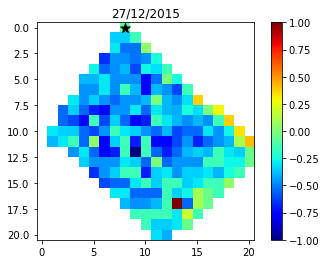

In [20]:
# Image
if check_results:

    fig = plt.figure()
    
    plt.imshow(img_mat_list[img_idx], cmap='jet', vmin=-1, vmax=1)
    
    plt.title(dates[img_idx].strftime("%d/%m/%Y"))
    
    plt.colorbar()
    plt.scatter(point[1], point[0], s=100, c='black', marker='*')
    
    #plt.savefig('ndvi_plot.png', dpi=300)
    
    plt.show()

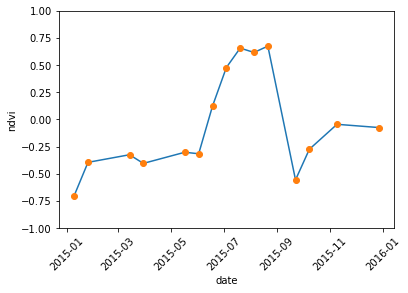

In [21]:
# Pixel time series
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in img_mat_list]
    
    fig = plt.figure()
    
    plt.plot(dates, ndvi_values, '-')
    plt.plot(dates, ndvi_values, 'o')
    
    #plt.vlines([datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0)], -1, 1, colors='b', linestyle='--')
    
    #plt.vlines([datetime.datetime(2014, 4, 1, 0, 0), datetime.datetime(2015, 4, 1, 0, 0), datetime.datetime(2016, 4, 1, 0, 0), datetime.datetime(2017, 4, 1, 0, 0)], -1, 1, colors='g', linestyle='--')
    #plt.vlines([datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2015, 9, 1, 0, 0), datetime.datetime(2016, 9, 1, 0, 0), datetime.datetime(2017, 9, 1, 0, 0)], -1, 1, colors='r', linestyle='--')
    
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi')
    #plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_tm.png', dpi=300)
    plt.show()



#### Smooth and gap fill

In [22]:
if check_results:
    # filter ndvi TM of a pixel
    dates_inter, ndvi_inter = ndvi_filter (dates, ndvi_values)
    




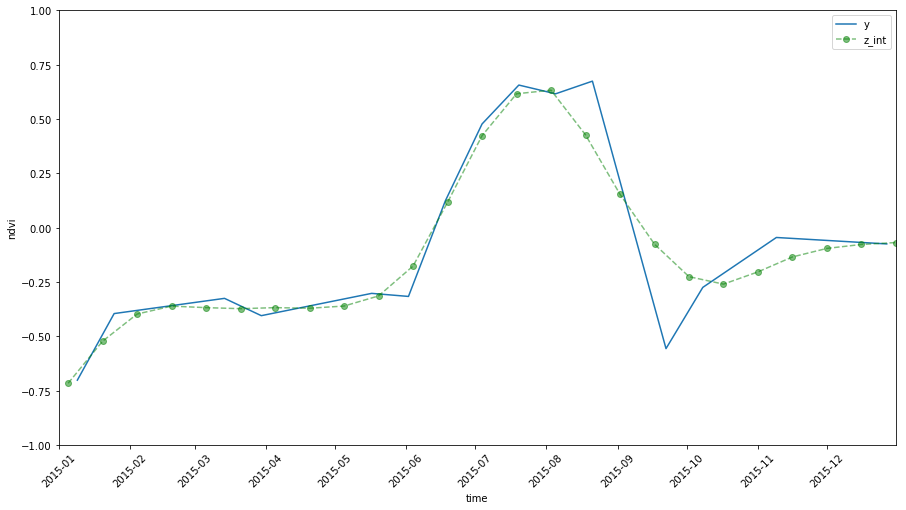

0.673886
-0.701306


In [23]:
if check_results:
    
    plt.figure(figsize=(15,8))
    plt.ylim(0,1)
    plt.plot(dates, ndvi_values, label='y')
    #plt.plot(xax1, z, 'rs', label='z', alpha=0.7)
    plt.plot(dates_inter, ndvi_inter, 'go--', label='z_int', alpha=0.5)

    plt.xticks(rotation=45)
    plt.xlabel('time')
    plt.ylabel('ndvi')
   
    plt.xlim((datetime.datetime(dates[0].year, 1, 1, 0, 0), datetime.datetime(dates[0].year, 12, 31, 0, 0)))
    plt.ylim((-1, 1))

    plt.legend()

    #plt.savefig('ndvi_' + str(dates[0].year) + '.png', dpi=300)

    plt.show()
    
    print(max(ndvi_values))
    print(min(ndvi_values))

In [24]:
# create an empty list of images to store interpolated ndvi data

ndvi_img_inter = []

for i in range(25):
    ndvi_img_inter.append(np.full_like(img_mat_list[0].data, -9999.0))


In [25]:
# interpolate ndvi for each pixel
dates_inter = []

for i in range(img_mat_list[0].shape[0]):
    for j in range(img_mat_list[0].shape[1]):
        
        #print(i,j)
        
        ndvi_tm = [img.data[i,j] for img in img_mat_list]
        
        n_novalue = ndvi_tm.count(-9999)
        
        if (n_novalue < len(img_mat_list)):
            
            ndvi_tm = [np.nan if x < -9998 else x for x in ndvi_tm]
            
            dates_inter, ndvi_inter = ndvi_filter (dates, ndvi_tm)

            ndvi_inter[np.isnan(ndvi_inter)] = -9999.0
        
            for idx,ndvi_inter in enumerate(ndvi_inter):
                ndvi_img_inter[idx][i,j] = ndvi_inter



# mask NaN values
for idx in range(len(ndvi_img_inter)):
    
    ndvi_img_inter[idx] = ma.masked_values (ndvi_img_inter[idx], -9999.0)
        
        #print(ndvi_inter)
        


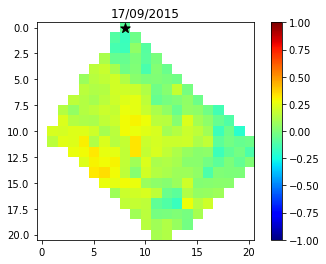

In [26]:
if check_results:
    
    #point = [10, 10]
    #point = [15, 10]


    #fig = plt.figure()
    #plt.imshow(img_mat_list[0])
    #plt.show()
    
    fig = plt.figure()
    
    img_idx = 17
    
    plt.imshow(ndvi_img_inter[img_idx], cmap='jet', vmin=-1, vmax=1)
    
    plt.title(dates_inter[img_idx].strftime("%d/%m/%Y"))
    
    plt.colorbar()
    plt.scatter(point[1], point[0], s=100, c='black', marker='*')
    
    #plt.savefig('ndvi_plot.png', dpi=300)
    
    plt.show()

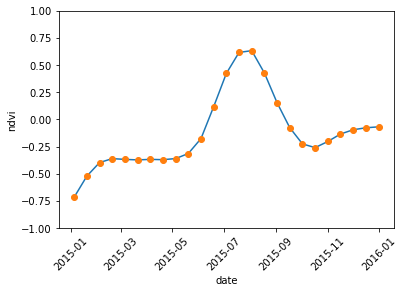

In [27]:
# get interpolated values for a given pixel

if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in ndvi_img_inter]
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    
    
    ndvi_values = np.array(ndvi_values)
    dates_inter = np.array(dates_inter)

    
    #plt.vlines([datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0)], -1, 1, colors='b', linestyle='--')
    
    #plt.vlines([datetime.datetime(2014, 4, 1, 0, 0), datetime.datetime(2015, 4, 1, 0, 0), datetime.datetime(2016, 4, 1, 0, 0), datetime.datetime(2017, 4, 1, 0, 0)], -1, 1, colors='g', linestyle='--')
    #plt.vlines([datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2015, 9, 1, 0, 0), datetime.datetime(2016, 9, 1, 0, 0), datetime.datetime(2017, 9, 1, 0, 0)], -1, 1, colors='r', linestyle='--')
    
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    #plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_tm.png', dpi=300)
    plt.show()
    
    
    
    
    
    

#### Find start and end dates of growing season

In [34]:
#
# Input: ndvi time series and dates
# Output: start and end dates and ndvi values of growing season
#
def find_start_end_date_season(dates_ts, ndvi_ts):
    
    # max value position 
    maxp = int(np.where(ndvi_ts == np.amax(ndvi_ts))[0])
    
    # start of season
        
    # first half
    x = [d.timetuple().tm_yday for d in dates_ts[0:maxp+1]]
    y = ndvi_ts[0:maxp+1]
    

    # choose best fit (linear, square, cubic)
    r2 = 0
    #p1 = None
    for d in [1,2,3]:
    
        coeffs_aux = np.polyfit(x=x, y=y, deg=d)
        p1_aux = np.poly1d(coeffs_aux)

        r2_aux = 1 - sum((y-p1_aux(x))**2) / sum((y-np.mean(y))**2)
    
        if r2_aux > r2:
            coeffs = coeffs_aux
            p1 = p1_aux
            r2 = r2_aux

    #if p1 is None:
    #    return -9999, -9999, -9999, -9999
            
    # derivative
    p2 = np.polyder(p1)
    
    
    for vp, vpd, d, ddate in zip(y,p2(x),x,dates_ts):
    
        #print(d, vpd, vp)
    
        # if derivative positive and ndvi value positive
        # get values and stop search
        if vpd > 0 and vp > 0:
        
            #print(d, vpd, vp)
        
            start_season_ndvi = vp
            start_season_date = ddate
        
            break
            

    # END OF SEASON
    
    x = [d.timetuple().tm_yday for d in dates_ts[maxp:]]
    y = ndvi_ts[maxp:]
    
    
    #x_fliped = np.flip(x, axis=None)
    #y_fliped = np.flip(y, axis=None)
    
    x_fliped = x[::-1]
    y_fliped = y[::-1]

    # choose best fit
    r2 = 0
    #p1 = None
    for d in [1,2,3]:
    
        coeffs_aux = np.polyfit(x=x, y=y_fliped, deg=d)
        p1_aux = np.poly1d(coeffs_aux)

        r2_aux = 1 - sum((y_fliped-p1_aux(x))**2) / sum((y_fliped-np.mean(y_fliped))**2)
    
        if r2_aux > r2:
            coeffs = coeffs_aux
            p1 = p1_aux
            r2 = r2_aux

    # derivative
    p2 = np.polyder(p1)
    
    idx = 0
    idx_fliped = 0
    for vp, vpd, d, d_f in zip(y_fliped,p2(x),x,x_fliped):
    
        #print(d, vpd, vp)
        
        # if derivative positive and ndvi value positive
        # get values and stop search
        if vpd > 0 and vp > 0:
        
            #print(d, vpd, vp)
        
            d = d_f
            
            idx_fliped = idx
            
            break
            
        idx = idx + 1
    
    
    
        

    idx_end = len(dates_ts) - (idx_fliped+1)
        
    end_season_date = dates_ts[idx_end]
    end_season_ndvi = ndvi_ts[idx_end]

    
    #plt.plot(x, y, 'o')
    #plt.plot(d, vp, 's')
    #plt.plot(x, p1(x))
    #plt.plot(x, p2(x))
    
    #print('poly')
    #print(p1)
    #print('derivative')
    #print(p2(x))
    #print('r2')


    #print(idx_end)

    
    return start_season_date, start_season_ndvi, end_season_date, end_season_ndvi


#print(start_season_date.strftime("%Y%j"), start_season_ndvi)
#print(end_season_date.strftime("%Y%j"), end_season_ndvi)

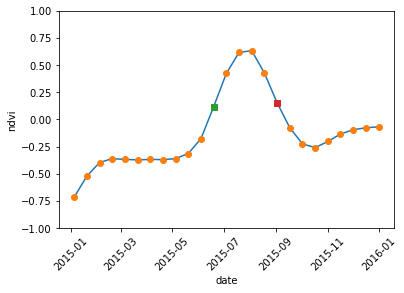

In [35]:
# get start and end date for a give pixel TS
if check_results:
    
    
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in ndvi_img_inter]
    
    
    start_season_date, start_season_ndvi, end_season_date, end_season_ndvi = find_start_end_date_season(dates_inter, ndvi_values)
    
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    plt.plot(start_season_date, start_season_ndvi, 's')
    plt.plot(end_season_date, end_season_ndvi, 's')
    
    ndvi_values = np.array(ndvi_values)
    dates_inter = np.array(dates_inter)

    
    #plt.vlines([datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0)], -1, 1, colors='b', linestyle='--')
    
    #plt.vlines([datetime.datetime(2014, 4, 1, 0, 0), datetime.datetime(2015, 4, 1, 0, 0), datetime.datetime(2016, 4, 1, 0, 0), datetime.datetime(2017, 4, 1, 0, 0)], -1, 1, colors='g', linestyle='--')
    #plt.vlines([datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2015, 9, 1, 0, 0), datetime.datetime(2016, 9, 1, 0, 0), datetime.datetime(2017, 9, 1, 0, 0)], -1, 1, colors='r', linestyle='--')
    
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    #plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_tm.png', dpi=300)
    plt.show()

In [36]:
# compute start and end dates of growing season for all images

start_date_img = np.full_like(ndvi_img_inter[0].data, -9999.0)
end_date_img = np.full_like(ndvi_img_inter[0].data, -9999.0)

for i in range(ndvi_img_inter[0].shape[0]):
    for j in range(ndvi_img_inter[0].shape[1]):
        
        ndvi_tm = ma.array([img[i,j] for img in ndvi_img_inter])
        
        if (ndvi_tm.count() > 0):
            
            #print(i,j)
            
            start_season_date, start_season_ndvi, end_season_date, end_season_ndvi = find_start_end_date_season(dates_inter, ndvi_tm)
            
            start_date_img[i,j] = start_season_date.strftime("%Y%j")
            end_date_img[i,j] = end_season_date.strftime("%Y%j")

/opt/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: RankWarning: Polyfit may be poorly conditioned
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: RankWarning: Polyfit may be poorly conditioned
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: RankWarning: Polyfit may be poorly conditioned
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in double_scalars


#### Check start and end dates of growing season

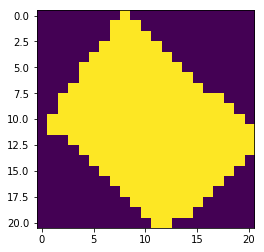

numpy.ndarray

In [37]:
if check_results:
    
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(end_date_img)
    
    plt.show()
    
type(end_date_img)

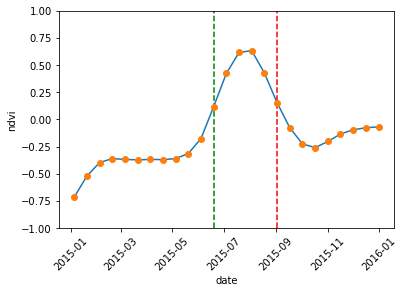

In [38]:
# check results for a given pixel
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in ndvi_img_inter]
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    #plt.plot( datetime.datetime.strptime(str(int(end_date_img[point[0], point[1]])), '%Y%j'), 0, 's')
    #plt.plot( datetime.datetime.strptime(str(int(start_date_img[point[0], point[1]])), '%Y%j'), 0, 's')
    
    start_date_px = datetime.datetime.strptime(str(int(start_date_img[point[0], point[1]])), '%Y%j')
    end_date_px = datetime.datetime.strptime(str(int(end_date_img[point[0], point[1]])), '%Y%j')
    
    plt.vlines([start_date_px], -1, 1, colors='g', linestyle='--')
    plt.vlines([end_date_px], -1, 1, colors='r', linestyle='--')
    
    
    ndvi_values = np.array(ndvi_values)
    dates_inter = np.array(dates_inter)

   
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    #plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_tm.png', dpi=300)
    plt.show()

#### Get NDVI differences

In [39]:
def get_ndvi_diffs (matrix_img_list):
    
    dif_matrix_img_list = []
    for i in range(len(matrix_img_list) - 1):
        
        diff = matrix_img_list[i+1] - matrix_img_list[i]
        
        dif_matrix_img_list.append(diff)
        
    return dif_matrix_img_list
        
dif_matrix_img_list = get_ndvi_diffs (ndvi_img_inter)

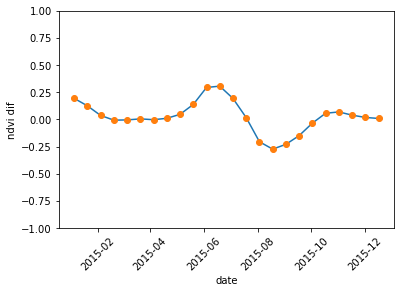

In [40]:
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in dif_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates_inter[:-1], ndvi_values, '-')
    plt.plot(dates_inter[:-1], ndvi_values, 'o')
    
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi dif')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()

Cumulative NDVI value for growing season

In [41]:

def get_ndvi_cumulative (matrix_img_list):
    
    cumulative_matrix_img_list = []
    
    cum_ndvi = []
    for idx,img_ndvi in enumerate(matrix_img_list):
        if idx == 0:
            cum_ndvi = img_ndvi
        else:
            cum_ndvi = cum_ndvi + img_ndvi
        
        cumulative_matrix_img_list.append(cum_ndvi)
        
    return cumulative_matrix_img_list
        
cumulative_matrix_img_list = get_ndvi_cumulative (ndvi_img_inter)

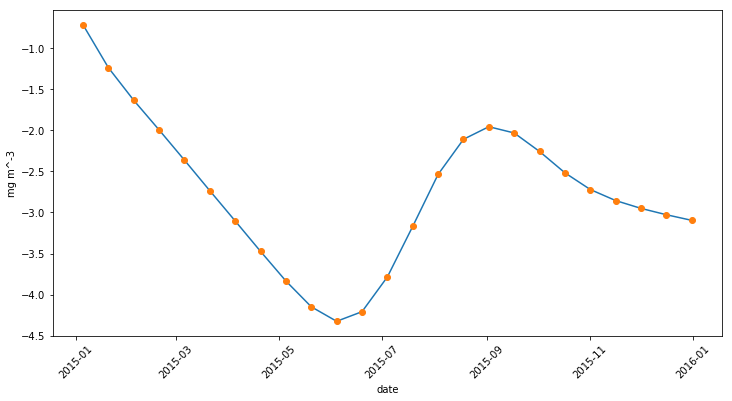

In [42]:
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in cumulative_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    
    #plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('mg m^-3')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()

Cumulative NDVI value for growing season

In [43]:
'''
def get_inverse_ndvi_cumulative (matrix_img_list):
    
    inv_cumulative_matrix_img_list = []
    
    inv_cum_ndvi = []
    for idx,img_ndvi in enumerate(reversed(matrix_img_list)):
        
        
        
        if idx == 0:
            inv_cum_ndvi = img_ndvi
        else:
            inv_cum_ndvi = inv_cum_ndvi + img_ndvi
            
        
        
        inv_cumulative_matrix_img_list.append(inv_cum_ndvi)
        
    return list(reversed(inv_cumulative_matrix_img_list))
        
inv_cumulative_matrix_img_list = get_inverse_ndvi_cumulative (ndvi_img_inter)
'''

'\ndef get_inverse_ndvi_cumulative (matrix_img_list):\n    \n    inv_cumulative_matrix_img_list = []\n    \n    inv_cum_ndvi = []\n    for idx,img_ndvi in enumerate(reversed(matrix_img_list)):\n        \n        \n        \n        if idx == 0:\n            inv_cum_ndvi = img_ndvi\n        else:\n            inv_cum_ndvi = inv_cum_ndvi + img_ndvi\n            \n        \n        \n        inv_cumulative_matrix_img_list.append(inv_cum_ndvi)\n        \n    return list(reversed(inv_cumulative_matrix_img_list))\n        \ninv_cumulative_matrix_img_list = get_inverse_ndvi_cumulative (ndvi_img_inter)\n'

In [44]:
'''
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    
    #plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('mg m^-3')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()
    
    print(ndvi_values)
'''

'\nif check_results:\n    \n    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]\n    \n    fig = plt.figure()\n    \n    plt.plot(dates_inter, ndvi_values, \'-\')\n    plt.plot(dates_inter, ndvi_values, \'o\')\n    \n    #plt.ylim((-1, 1))\n    #plt.set_xlim([0, 5])\n\n    plt.xticks(rotation=45)\n    plt.xlabel(\'date\')\n    plt.ylabel(\'mg m^-3\')\n    #plt.title(\'Chlorophyll-a concentration (percentile 90)\nAzores (\' + str_area_title + \')\')\n    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)\n\n    #plt.savefig(\'ndvi_graph.png\', dpi=300)\n    plt.show()\n    \n    print(ndvi_values)\n'

In [45]:
'''
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in cumulative_matrix_img_list]
    
    
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    
    #plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('mg m^-3')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()
    
    print(ndvi_values)
    
'''

'\nif check_results:\n    \n    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]\n    \n    fig = plt.figure()\n    \n    plt.plot(dates_inter, ndvi_values, \'-\')\n    plt.plot(dates_inter, ndvi_values, \'o\')\n    \n    \n    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in cumulative_matrix_img_list]\n    \n    \n    \n    plt.plot(dates_inter, ndvi_values, \'-\')\n    plt.plot(dates_inter, ndvi_values, \'o\')\n    \n    #plt.ylim((-1, 1))\n    #plt.set_xlim([0, 5])\n\n    plt.xticks(rotation=45)\n    plt.xlabel(\'date\')\n    plt.ylabel(\'mg m^-3\')\n    #plt.title(\'Chlorophyll-a concentration (percentile 90)\nAzores (\' + str_area_title + \')\')\n    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)\n\n    #plt.savefig(\'ndvi_graph.png\', dpi=300)\n    plt.show()\n    \n    print(ndvi_values)\n    \n'

NDVI peak value

In [46]:
def get_ndvi_peak (matrix_img_list):
  
    peak_ndvi = []
    for idx,img_ndvi in enumerate(matrix_img_list):
        if idx == 0:
            peak_ndvi = img_ndvi
        else:
            peak_ndvi = np.where(peak_ndvi < img_ndvi, img_ndvi, peak_ndvi)
        
    return peak_ndvi
        
peak_matrix_img = get_ndvi_peak (ndvi_img_inter)

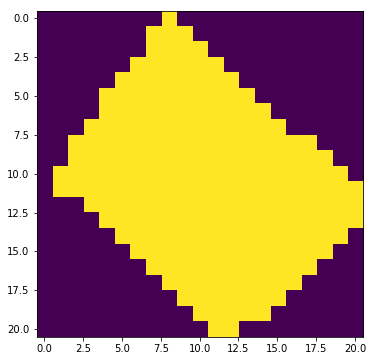

0.962331
-9999.0


In [47]:
if check_results:
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(peak_matrix_img)
    
    plt.show()
    
    print(peak_matrix_img.max())
    print(peak_matrix_img.min())

#### Mask -9999 values

In [48]:
start_date_img_ma = ma.masked_array(start_date_img, mask = start_date_img < -9998, fill_value=-9999)

type(start_date_img_ma)

numpy.ma.core.MaskedArray

In [49]:
end_date_img_ma = ma.masked_array(end_date_img, mask = end_date_img < -9998, fill_value=-9999)

type(end_date_img_ma)

numpy.ma.core.MaskedArray

In [50]:
type(dif_matrix_img_list[0])

numpy.ma.core.MaskedArray

In [51]:
type(cumulative_matrix_img_list[0])

numpy.ma.core.MaskedArray

In [52]:
peak_matrix_img_ma = ma.masked_array(peak_matrix_img, mask = end_date_img < -9998)

type(peak_matrix_img_ma[0])

numpy.ma.core.MaskedArray

## Per Parcel

In [53]:
#start_date_img_ma.mean()

col_names = ['start_date', 'end_date', 'start_growing_season']
start_date_parcel = pd.DataFrame(columns=col_names)
start_date_parcel = start_date_parcel.append({'start_date': dates_inter[0], 'end_date': dates_inter[-1], 'start_growing_season': int(start_date_img_ma.mean())}, ignore_index=True)

start_date_parcel

,start_date,end_date,start_growing_season
0,2015-01-05,2015-12-31,2015174


In [54]:
#end_date_img_ma.mean()

col_names = ['start_date', 'end_date', 'end_growing_season']
end_date_parcel = pd.DataFrame(columns=col_names)
end_date_parcel = end_date_parcel.append({'start_date': dates_inter[0], 'end_date': dates_inter[-1], 'end_growing_season': int(end_date_img_ma.mean())}, ignore_index=True)

end_date_parcel

,start_date,end_date,end_growing_season
0,2015-01-05,2015-12-31,2015261


In [55]:
#[mat.mean() for mat in dif_matrix_img_list]

col_names = ['start_date', 'end_date', 'dif_ndvi']
dif_ndvi_parcel = pd.DataFrame(columns=col_names)

for idx in range(len(dates_inter)-1):
    
    dif_ndvi_parcel = dif_ndvi_parcel.append({'start_date': dates_inter[idx], 'end_date': dates_inter[idx+1], 'dif_ndvi': dif_matrix_img_list[idx].mean()}, ignore_index=True)

dif_ndvi_parcel

,start_date,end_date,dif_ndvi
0,2015-01-05,2015-01-20,0.091755
1,2015-01-20,2015-02-04,0.054402
2,2015-02-04,2015-02-19,0.011023
3,2015-02-19,2015-03-06,0.000324
4,2015-03-06,2015-03-21,0.022128
5,2015-03-21,2015-04-05,0.030944
6,2015-04-05,2015-04-20,0.006479
7,2015-04-20,2015-05-05,0.006349
8,2015-05-05,2015-05-20,0.035801
9,2015-05-20,2015-06-04,0.103699


In [56]:
#[mat.mean() for mat in cumulative_matrix_img_list]

col_names = ['start_date', 'end_date', 'cumulative_ndvi']
cumulative_ndvi_parcel = pd.DataFrame(columns=col_names)

for idx in range(len(dates_inter)):
    
    cumulative_ndvi_parcel = cumulative_ndvi_parcel.append({'start_date': dates_inter[0], 'end_date': dates_inter[idx], 'cumulative_ndvi': cumulative_matrix_img_list[idx].mean()}, ignore_index=True)

cumulative_ndvi_parcel

,start_date,end_date,cumulative_ndvi
0,2015-01-05,2015-01-05,-0.557688
1,2015-01-05,2015-01-20,-1.023622
2,2015-01-05,2015-02-04,-1.435153
3,2015-01-05,2015-02-19,-1.835661
4,2015-01-05,2015-03-06,-2.235845
5,2015-01-05,2015-03-21,-2.613901
6,2015-01-05,2015-04-05,-2.961014
7,2015-01-05,2015-04-20,-3.301647
8,2015-01-05,2015-05-05,-3.635930
9,2015-01-05,2015-05-20,-3.934413


In [57]:
#peak_matrix_img_ma.mean()

col_names = ['start_date', 'end_date', 'peak_ndvi']
peak_ndvi_parcel = pd.DataFrame(columns=col_names)
peak_ndvi_parcel = peak_ndvi_parcel.append({'start_date': dates_inter[0], 'end_date': dates_inter[-1], 'peak_ndvi': peak_matrix_img_ma.mean()}, ignore_index=True)

peak_ndvi_parcel

,start_date,end_date,peak_ndvi
0,2015-01-05,2015-12-31,0.641125


#### Export results

In [58]:
# get metada data
projection, geotransform, no_data_value, data_type = get_metadata(file_list[0])

first_part = os.path.basename(file_list[0])[0:4]
areaOfInterestName = nameOfRegion['value']

##### Export to excel

In [ ]:
var_name = 'ndviStats'

start_date = dates_inter[0]
end_date = dates_inter[-1]

excel_output_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.xlsx'
    
excel_output_name = os.path.join(output_folder, excel_output_name)

print(excel_output_name)

with pd.ExcelWriter(excel_output_name) as writer:  # doctest: +SKIP
    start_date_parcel.to_excel(writer, sheet_name='start_growing_season')
    end_date_parcel.to_excel(writer, sheet_name='end_growing_season')
    dif_ndvi_parcel.to_excel(writer, sheet_name='dif_ndvi')
    cumulative_ndvi_parcel.to_excel(writer, sheet_name='cumulative_ndvi')
    peak_ndvi_parcel.to_excel(writer, sheet_name='peak_ndvi')


difference ndvi

In [ ]:

var_name = 'difNdvi'

for idx in range(len(dif_ndvi_parcel)):
    
    print(dif_ndvi_parcel['start_date'][idx])
    
    start_date = dif_ndvi_parcel['start_date'][idx]
    end_date = dif_ndvi_parcel['end_date'][idx]
    
    dif_matrix_img = dif_matrix_img_list[idx]
    
    dif_ndvi_img_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.tif'
    
    dif_ndvi_img_name = os.path.join(output_folder, dif_ndvi_img_name)
    
    print(dif_ndvi_img_name)
    
    write_output_image(dif_ndvi_img_name, dif_matrix_img, 'GTiff', data_type, None, projection, geotransform, no_data_value)
    
    write_properties_file(dif_ndvi_img_name, start_date, end_date, regionOfInterest['value'])


Cumulative ndvi

In [ ]:
var_name = 'cumulativeNdvi'

for idx in range(len(cumulative_ndvi_parcel)):
    
    print(cumulative_ndvi_parcel['start_date'][idx])
    
    start_date = cumulative_ndvi_parcel['start_date'][idx]
    end_date = cumulative_ndvi_parcel['end_date'][idx]
    
    cum_matrix_img = cumulative_matrix_img_list[idx]
    
    cum_ndvi_img_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.tif'
    
    cum_ndvi_img_name = os.path.join(output_folder, cum_ndvi_img_name)
    
    print(cum_ndvi_img_name)
    
    write_output_image(cum_ndvi_img_name, cum_matrix_img, 'GTiff', data_type, None, projection, geotransform, no_data_value)
    
    write_properties_file(cum_ndvi_img_name, start_date, end_date, regionOfInterest['value'])

Peak value

In [ ]:
#peak_matrix_img_ma
#peak_ndvi_parcel

var_name = 'ndviPeak'

start_date = peak_ndvi_parcel['start_date'][0]
end_date = peak_ndvi_parcel['end_date'][0]

peak_ndvi_img_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.tif'
    
peak_ndvi_img_name = os.path.join(output_folder, peak_ndvi_img_name)
    
print(peak_ndvi_img_name)

write_output_image(peak_ndvi_img_name, peak_matrix_img, 'GTiff', data_type, None, projection, geotransform, no_data_value)

write_properties_file(peak_ndvi_img_name, start_date, end_date, regionOfInterest['value'])

start growing season date

In [ ]:
#start_date_img_ma
#start_date_parcel

var_name = 'startSeasonNdvi'

start_date = start_date_parcel['start_date'][0]
end_date = start_date_parcel['end_date'][0]

start_date_ndvi_img_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.tif'
    
start_date_ndvi_img_name = os.path.join(output_folder, start_date_ndvi_img_name)
    
print(start_date_ndvi_img_name)

write_output_image(start_date_ndvi_img_name, start_date_img_ma, 'GTiff', gdal.GDT_Int32, None, projection, geotransform, no_data_value)

write_properties_file(start_date_ndvi_img_name, start_date, end_date, regionOfInterest['value'])

end growing season date

In [ ]:
#end_date_img_ma
#end_date_parcel

var_name = 'endSeasonNdvi'

start_date = end_date_parcel['start_date'][0]
end_date = end_date_parcel['end_date'][0]

end_date_ndvi_img_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.tif'
    
end_date_ndvi_img_name = os.path.join(output_folder, end_date_ndvi_img_name)
    
print(end_date_ndvi_img_name)

write_output_image(end_date_ndvi_img_name, end_date_img_ma, 'GTiff', gdal.GDT_Int32, None, projection, geotransform, no_data_value)

write_properties_file(end_date_ndvi_img_name, start_date, end_date, regionOfInterest['value'])

#### Remove temporay files and folders

In [ ]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)